In [1]:
import torchvision
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import logging
from torchvision import transforms

dtype = torch.float
# device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU

### Load Fashion MNIST dataset bundled with PyTorch

In [2]:
tf = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)),
])
ds = torchvision.datasets.FashionMNIST('./datasets', download=True, transform=tf)
ds_test = torchvision.datasets.FashionMNIST('./datasets', train=False, transform=tf)

print("Dataset size: test=%s train=%s" % (len(ds), len(ds_test)))

Dataset size: test=60000 train=10000


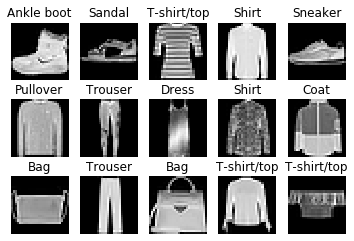

In [3]:
# Show sample images
sample_rows, sample_cols = 3, 5
for idx in range(sample_rows*sample_cols):
    sample_idx = idx*13
    plt.subplot(sample_rows, sample_cols, idx+1)
    plt.title(ds.classes[ds.targets[sample_idx]])
    plt.axis('off')
    plt.imshow(ds.data[sample_idx], cmap='gray')

### Model attempt 1: one hidden layer + ReLU + softmax + NLL loss

In [70]:
class M1:
    batch_size = 100
    hidden_dim = 300
    num_epochs = 20
    input_dim = 28*28
    output_dim = len(ds.classes)
    learning_rate = 0.1

    def __init__(self):
        self.weights_1 = torch.randn(self.hidden_dim, self.input_dim, requires_grad=True,
                                     device=device, dtype=dtype)
        self.weights_2 = torch.randn(self.output_dim, self.hidden_dim, requires_grad=True,
                                     device=device, dtype=dtype)

    def loss(self, x, y):
        x = x.to(device).reshape(len(x), self.input_dim).float() / 255.0
        y = y.to(device)
        model = F.linear(x, self.weights_1)
        model = F.relu(model)
        model = F.linear(model, self.weights_2)
        return F.cross_entropy(model, y, reduction='mean')

    def predict(self, x):
        x = x.to(device).reshape(len(x), self.input_dim).float() / 255.0
        model = F.linear(x, self.weights_1)
        model = F.relu(model)
        model = F.linear(model, self.weights_2)
        _, pred = torch.max(F.softmax(model, dim=1), dim=1)
        return pred

    def evaluate(self):
        with torch.no_grad():
            test_loss = self.loss(ds_test.data, ds_test.targets)
            acc = (self.predict(ds_test.data) == ds_test.targets.to(device)).float().mean()
            print("test loss %.2f acc %0.2f" % (test_loss.item(), acc.item()))

    def train(self):
        optimizer = torch.optim.Adam([self.weights_1, self.weights_2], lr=self.learning_rate)
        loader = torch.utils.data.DataLoader(ds, batch_size=self.batch_size, shuffle=True)
        for epoch_idx in range(self.num_epochs):
            for batch_idx, (batch_x, batch_y) in enumerate(loader):
                optimizer.zero_grad()
                loss = self.loss(batch_x, batch_y)
                if batch_idx*self.batch_size % 30000 == 0:
                    print("Batch % 4d, batch train loss %.2f" % (batch_idx, loss.item()))
                loss.backward()
                optimizer.step()
            print("=== Epoch %d:" % epoch_idx, end=" ")
            self.evaluate()

In [71]:
m1 = M1()
m1.train()

Batch    0, batch train loss 2.45
Batch  300, batch train loss 0.56
=== Epoch 0: test loss 64.60 acc 0.82
Batch    0, batch train loss 0.32
Batch  300, batch train loss 0.57
=== Epoch 1: test loss 54.35 acc 0.85
Batch    0, batch train loss 0.37
Batch  300, batch train loss 0.27
=== Epoch 2: test loss 52.04 acc 0.86
Batch    0, batch train loss 0.47
Batch  300, batch train loss 0.38
=== Epoch 3: test loss 56.89 acc 0.86
Batch    0, batch train loss 0.30
Batch  300, batch train loss 0.23
=== Epoch 4: test loss 61.40 acc 0.86
Batch    0, batch train loss 0.56
Batch  300, batch train loss 0.45
=== Epoch 5: test loss 60.46 acc 0.87
Batch    0, batch train loss 0.19
Batch  300, batch train loss 0.18
=== Epoch 6: test loss 57.56 acc 0.87
Batch    0, batch train loss 0.22
Batch  300, batch train loss 0.33
=== Epoch 7: test loss 65.43 acc 0.86
Batch    0, batch train loss 0.40
Batch  300, batch train loss 0.15
=== Epoch 8: test loss 59.12 acc 0.87
Batch    0, batch train loss 0.30
Batch  300, 

'Pullover'

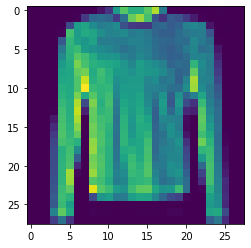

In [89]:
ti = 8919
plt.imshow(ds_test.data[ti])
ds_test.classes[m1.predict(ds_test.data[ti:ti+1])]

device(type='cuda', index=0)